In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask # just to make sure dask is installed because xarray should use it
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path

from utils.metrics import find_rank, compute_chi_squared, compute_cdf, compute_sum_of_squared_deviations
from utils.plot import plot_rank_hist, calibration_plot, calibration_plot_range
 
np.set_printoptions(suppress=True)

# Set directory to save results and whether you want to display results in this notebook

In [3]:
SAVE_DIR = Path('/net/argon/landclim/kraftb/machflow_engression/results/expectiles/')
DISPLAY = True # whether to display plots in notebook (they are saved to files in either case)

# Load Data

In [4]:
ds = xr.open_zarr('/net/argon/landclim/kraftb/machflow_engression/runs_expectiles/default/xval/fold_000/preds.zarr/')
ds = ds.loc[{'station': ds['folds'] > 0}]
ds = ds[['Qmm', 'Qmm_mod']]
ds

<xarray.Dataset> Size: 152MB
Dimensions:  (station: 85, time: 4383, member: 101)
Coordinates:
  * member   (member) float64 808B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99 1.0
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 35kB 2011-01-01 2011-01-02 ... 2022-12-31
Data variables:
    Qmm      (station, time) float32 1MB dask.array<chunksize=(40, 4383), meta=np.ndarray>
    Qmm_mod  (member, station, time) float32 151MB dask.array<chunksize=(10, 40, 4383), meta=np.ndarray>

In [5]:
observations = ds.Qmm.isel(time=slice(365, None))
observations

<xarray.DataArray 'Qmm' (station: 85, time: 4018)> Size: 1MB
dask.array<getitem, shape=(85, 4018), dtype=float32, chunksize=(40, 4018), chunktype=numpy.ndarray>
Coordinates:
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 32kB 2012-01-01 2012-01-02 ... 2022-12-31

In [6]:
pred = ds.Qmm_mod.isel(time=slice(365, None))
pred

<xarray.DataArray 'Qmm_mod' (member: 101, station: 85, time: 4018)> Size: 138MB
dask.array<getitem, shape=(101, 85, 4018), dtype=float32, chunksize=(10, 40, 4018), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) float64 808B 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99 1.0
  * station  (station) <U9 3kB 'CHFO-0057' 'CHFO-0073' ... 'CHFO-0263'
  * time     (time) datetime64[ns] 32kB 2012-01-01 2012-01-02 ... 2022-12-31

# Run main evaluations and create plots

### Overall results

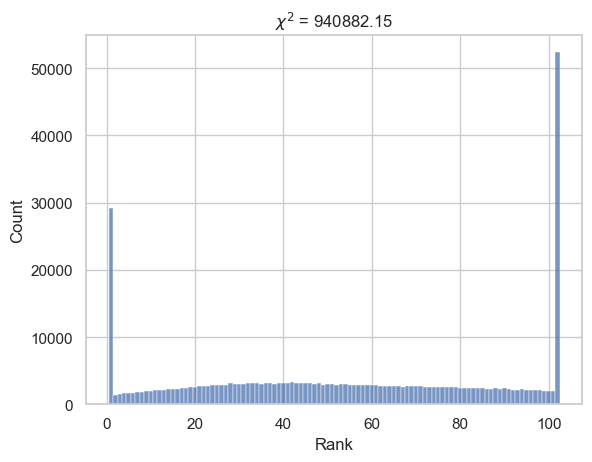

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


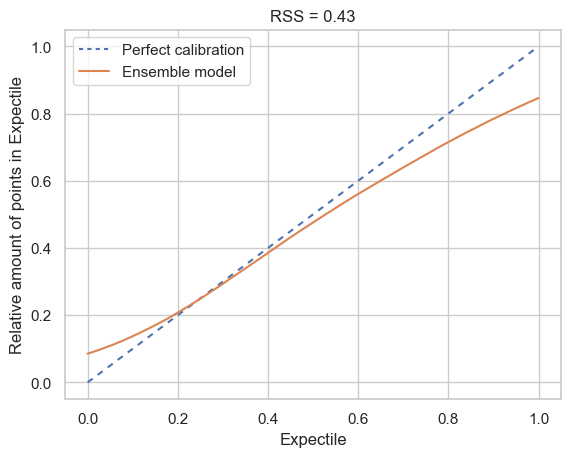

In [7]:
ranks = xr.apply_ufunc(
    find_rank,
    observations.compute(),             # Observations with ["station", "time"]
    pred.compute(),                     # Expectile predictions with ["member", "station", "time"]
    input_core_dims=[[], ["member"]],   # Observations have no "member" dim, members do
    output_core_dims=[[]],              # Output is scalar per observation
    vectorize=True,                     # Apply function element-wise
    dask="parallelized",                # Enable Dask parallelization if needed
    output_dtypes=[np.int16],           # Output type
)

ranks = ranks.compute().data.flatten() # Work with flat numpy array
ranks = ranks[ranks != -1]
chi_squared = compute_chi_squared(ranks=ranks, num_members=len(pred.member))

save_dir_rank_hist = Path(SAVE_DIR / 'rank_histograms')
save_dir_rank_hist.mkdir(exist_ok=True, parents=True)
plot_rank_hist(
    ranks=ranks,
    title=f'$\chi^2$ = {chi_squared:.2f}',
    save_file=save_dir_rank_hist / f'rankhist.svg',
    display=DISPLAY
) 

expectile_indices = ranks - 1
expectiles = ds.member.values

cdf_pred = compute_cdf(quantile_indices=expectile_indices, num_quantiles=len(expectiles))
sum_of_squared_deviations = compute_sum_of_squared_deviations(expectiles, cdf_pred)

save_dir_calibration_plot = Path(SAVE_DIR / f'calibration_plots')
save_dir_calibration_plot.mkdir(exist_ok=True, parents=True)
calibration_plot(
    x=expectiles,
    cdf_pred=cdf_pred,
    title=f'RSS = {sum_of_squared_deviations:.2f}',
    x_name='Expectile',
    save_file=save_dir_calibration_plot / f'calib_plot.eps',
    display=DISPLAY
)

### Results per station

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

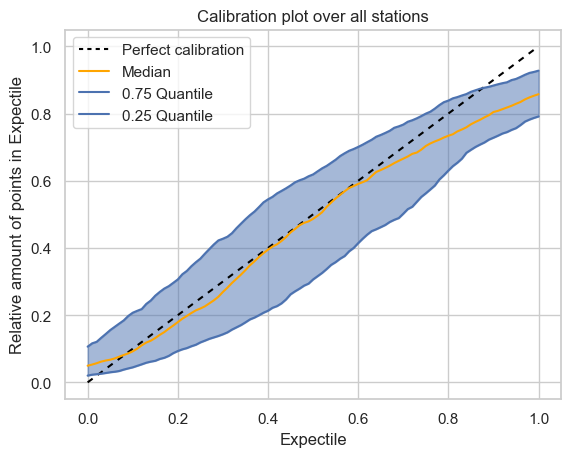

In [8]:
results = {}
cdfs = []
for station in pred.station:
    results[station.data.item()] = {}
    station_obs = observations.sel(station=station)
    station_pred = pred.sel(station=station)

    ranks = xr.apply_ufunc(
        find_rank,
        station_obs.compute(),              # Observations with ["time"]
        station_pred.compute(),             # Expectile predictions with ["member", "time"]
        input_core_dims=[[], ["member"]],   # Observations have no "member" dim, members do
        output_core_dims=[[]],              # Output is scalar per observation
        vectorize=True,                     # Apply function element-wise
        dask="parallelized",                # Enable Dask parallelization if needed
        output_dtypes=[np.int16],           # Output type
    )

    ranks = ranks.compute().data.flatten() # Work with flat numpy array
    ranks = ranks[ranks != -1]
    chi_squared = compute_chi_squared(ranks=ranks, num_members=len(pred.member))
    results[station.data.item()]['Chi^2'] = chi_squared

    save_dir_rank_hist = Path(SAVE_DIR / f'rank_histograms/per-station')
    save_dir_rank_hist.mkdir(exist_ok=True, parents=True)
    plot_rank_hist(
        ranks=ranks,
        title=f'$\chi^2$ = {chi_squared:.2f}',
        save_file=save_dir_rank_hist / f'rankhist_{station.data.item()}.eps',
        display=False
    ) 

    expectile_indices = ranks - 1
    expectiles = ds.member.values

    cdf_pred = compute_cdf(quantile_indices=expectile_indices, num_quantiles=len(expectiles))
    cdfs.append(cdf_pred)
    sum_of_squared_deviations = compute_sum_of_squared_deviations(expectiles, cdf_pred)
    results[station.data.item()]['RSS'] = sum_of_squared_deviations

    save_dir_calibration_plot = Path(SAVE_DIR / f'calibration_plots/per-station')
    save_dir_calibration_plot.mkdir(exist_ok=True, parents=True)
    calibration_plot(
        x=expectiles,
        cdf_pred=cdf_pred,
        title=f'RSS = {sum_of_squared_deviations:.2f}',
        x_name='Expectile',
        save_file=save_dir_calibration_plot / f'calib_plot_{station.data.item()}.eps',
        display=False
    )

# Make calibration plot over all stations, show everything between low and high quantile as shaded area
calibration_plot_range(
    x=expectiles,
    cdf_per_station=np.array(cdfs),
    high_quantile=0.75,
    low_quantile=0.25,
    title='Calibration plot over all stations',
    x_name='Expectile',
    save_file=Path(SAVE_DIR / 'calibration_plots/calib_plot_range.eps'),
    display=DISPLAY
)

In [9]:
res_df = pd.DataFrame(results)
res_df = res_df.sort_index(axis=1)
res_df.to_csv(SAVE_DIR / 'results.csv')
res_df

,CHFO-0057,CHFO-0073,CHFO-0081,CHFO-0083,CHFO-0086,CHFO-0088,CHFO-0089,CHFO-0090,CHFO-0094,CHFO-0095,...,CHFO-0238,CHFO-0240,CHFO-0241,CHFO-0242,CHFO-0243,CHFO-0248,CHFO-0250,CHFO-0251,CHFO-0258,CHFO-0263
Chi^2,15108.142359,6699.412643,9345.929318,23662.515816,1857.788950,71102.283723,7019.425585,14205.881533,1280.059731,69013.441513,...,12308.397213,44544.001991,24818.298656,49902.581384,43402.658039,13523.359881,25301.745147,14151.251369,22185.010949,3388.195122
RSS,1.153301,0.902206,0.569826,4.152338,1.314236,12.612305,2.296740,4.403357,0.105603,13.088034,...,0.858533,3.495390,3.465337,6.696069,7.250188,1.772905,2.399726,1.739188,3.123472,1.019492
